# Apple Products Image Classification Notebook

In this notebook, we're making an image classifier which can classify three major Apple products: Macbook, iPad, and iPhone. Sometimes, when presented in image, they look similar to one another, with their signature black bezels, clear screen, as well as sleek design. Some iPads also come with Magic Keyboard, and it starts to look like a Macbook.

Can we use deep learning to classify these product images? What model architecture should we use? How should we train our models? It will all be answered in this notebook.

## Part 1: Import Data

First, we'll import the Python packages and our raw dataset. The dataset is scraped by selecting top images from Google Images Search by using a Chrome [plug-in](https://chrome.google.com/webstore/detail/download-all-images/ifipmflagepipjokmbdecpmjbibjnakm).

The dataset can be loaded in various ways. In this notebook, the dataset is stored in a zip file which is stored in my Google Drive.

The same dataset (in zip format) is available in https://www.kaggle.com/radvian/apple-products-image-dataset

In [88]:
# import Python libraries

import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
import numpy as np
import string
import random
from random import randint
import warnings
import PIL
from PIL import Image
warnings.simplefilter("ignore", UserWarning)

# import dataset which is mounted in Google Drive

local_zip = '/content/drive/MyDrive/Colab Notebooks/Apple Products/Apple Products.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [2]:
print('Number of MacBook images: ',len(os.listdir('/tmp/Apple Products/Macbook/')))
print('Number of iPad images: ',len(os.listdir('/tmp/Apple Products/iPad/')))
print('Number of iPhone images: ',len(os.listdir('/tmp/Apple Products/iPhone/')))

Number of MacBook images:  403
Number of iPad images:  555
Number of iPhone images:  556


In [3]:
# making directories to store training and testing data

try:
  os.mkdir('/tmp/Apple')
  os.mkdir('/tmp/Apple/training')
  os.mkdir('/tmp/Apple/testing')
  os.mkdir('/tmp/Apple/training/iPad')
  os.mkdir('/tmp/Apple/training/iPhone')
  os.mkdir('/tmp/Apple/training/Macbook')
  os.mkdir('/tmp/Apple/testing/iPad')
  os.mkdir('/tmp/Apple/testing/iPhone')
  os.mkdir('/tmp/Apple/testing/Macbook')
except OSError:
  pass

In [4]:
# splitting the data into training and testing (validation) set

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


ipad_source_path = "/tmp/Apple Products/iPad/"
train_ipad_path = "/tmp/Apple/training/iPad/"
test_ipad_path = "/tmp/Apple/testing/iPad/"

iphone_source_path = "/tmp/Apple Products/iPhone/"
train_iphone_path = "/tmp/Apple/training/iPhone/"
test_iphone_path = "/tmp/Apple/testing/iPhone/"

macbook_source_path = "/tmp/Apple Products/Macbook/"
train_macbook_path = "/tmp/Apple/training/Macbook/"
test_macbook_path = "/tmp/Apple/testing/Macbook/"

split_size = .9
split_data(ipad_source_path, train_ipad_path, test_ipad_path, split_size)
split_data(iphone_source_path, train_iphone_path, test_iphone_path, split_size)
split_data(macbook_source_path, train_macbook_path, test_macbook_path, split_size)


Now, to get a sense of what our images look like, we can run this function many times to see examples of images from each class. Each run will randomize the image chosen. 

In [5]:
def load_random_images():
  from IPython.display import Image 

  macbook_path = '/tmp/Apple/training/Macbook/'
  ipad_path = '/tmp/Apple/training/iPad/'
  iphone_path = '/tmp/Apple/training/iPhone/'

  macbook = random.choice(os.listdir(macbook_path))
  ipad = random.choice(os.listdir(ipad_path))
  iphone = random.choice(os.listdir(iphone_path))

  print('Macbook:')
  macbook_img = Image(filename = macbook_path+macbook)
  display(macbook_img)

  print('iPad:')
  ipad_img = Image(filename = ipad_path+ipad)
  display(ipad_img)

  print('iPhone:')
  iphone_img = Image(filename = iphone_path+iphone)
  display(iphone_img)

Macbook:


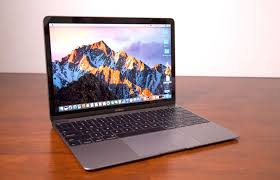

iPad:


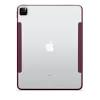

iPhone:


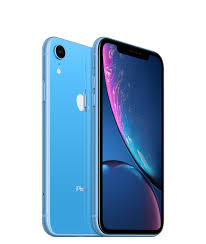

In [6]:
# Run this cell as much as you want to see random images from each class!
load_random_images()

## Part 2: Preparation for Training our Models

After splitting the images into training and validation set, we're going to use Keras ```ImageDataGenerator``` to preprocess our images. 

There are three usages of ```ImageDataGenerator```. First, this is to create 'data generators' which can label and load training data into our model.

By using ```ImageDataGenerator```, the labeling part of our training and validation images are done automatically. It will give the same label to images within the same folder. Since we have 3 folders in our training and testing set ('Macbook', 'iPad', and 'iPhone'), the data will be labeled categorically as '0', '1', and '2' respectively.

Second, this is to augment our images. In short, this is done to make our model more robust and still can identify images even if the image have noise or is flipped upside down or is not 'straightened'. 

If we only feed 'ideal' images (for example, official renders, official photos, photos which are taken by photographers using high-end cameras), our model won't be able to recognize 'amateur-ish' images (for example, images taken hurriedly by phone camera on a badly-lit room).

Third, we can rescale the images (which comes in various sizes) so it can be fed into the model. Our neural network cannot receive inputs which have different shapes, so we need to make sure all images are rescaled and resized into a particular shape.

You can change the augmentation parameters as well as the resizing metrics to see if your combination can improve the model accuracy.

In [7]:
TRAINING_DIR = '/tmp/Apple/training/'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest') 

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size = 128,
                                                    class_mode = 'categorical',
                                                    target_size = (150,150))

VALIDATION_DIR = "/tmp/Apple/testing"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=128,
                                                              class_mode='categorical',
                                                              target_size=(150, 150))

Found 1360 images belonging to 3 classes.
Found 153 images belonging to 3 classes.


Next, we'll prepare functions to plot our training results. There are two metrics which will be shown: accuracy and loss. A good training result will have:
- an increase of accuracy per epoch passed for both training and validation set
- a decrease of loss per epoch passed for both training and validation set
- does not overfit: training accuracy does not surpass validation accuracy by a lot
- does not underfit: training accuracy does not trail behind validation accuracy by a lot

In [8]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def plot_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.figure(figsize=(5,5))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])


def plot_loss(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure(figsize=(5,5))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

def plot_history(history):
  plot_acc(history)
  plot_loss(history)

## Part 3: Training a Basic Model with Convolutional Neural Network

We'll first train a basic CNN model in an attempt to classify images into its respectie classes. Convolutional Neural Networks are a class of deep neural networks which are fully connected (each neuron in a layer is connected to all neurons in the next layers).

CNN is mostly used in image classification task. Because of its hierarchial structure (multiple layers stuck on top of each other) and interconnectedness, CNN can use each pixel in an image as well as its adjacent pixels and process them - extracting their features using convolution, then applying a Dense layer at the end to make prediction.

Epoch 1/20
11/11 [==============================] - 18s 2s/step - loss: 1.1457 - accuracy: 0.3801 - val_loss: 1.0927 - val_accuracy: 0.4052
Epoch 2/20
11/11 [==============================] - 18s 2s/step - loss: 1.0825 - accuracy: 0.3890 - val_loss: 1.0900 - val_accuracy: 0.3660
Epoch 3/20
11/11 [==============================] - 18s 2s/step - loss: 1.0793 - accuracy: 0.4022 - val_loss: 1.0858 - val_accuracy: 0.4248
Epoch 4/20
11/11 [==============================] - 18s 2s/step - loss: 1.0703 - accuracy: 0.3956 - val_loss: 1.0799 - val_accuracy: 0.3660
Epoch 5/20
11/11 [==============================] - 17s 2s/step - loss: 1.0634 - accuracy: 0.3787 - val_loss: 1.0669 - val_accuracy: 0.4052
Epoch 6/20
11/11 [==============================] - 18s 2s/step - loss: 1.0556 - accuracy: 0.3978 - val_loss: 1.0464 - val_accuracy: 0.4379
Epoch 7/20
11/11 [==============================] - 18s 2s/step - loss: 1.0409 - accuracy: 0.4331 - val_loss: 1.0380 - val_accuracy: 0.4967
Epoch 8/20
11/11 [==

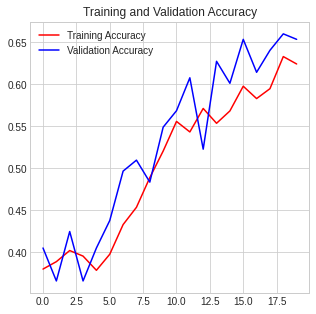

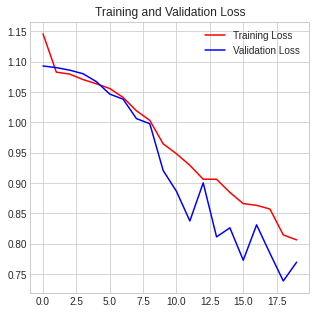

In [9]:
tf.keras.backend.clear_session()
model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_simple.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_simple = model_simple.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)

plot_history(history_simple)

The model above should be adequate if our image classification task is to classify mnist or Fashion-Mnist data. However, it seems that our model's accuracy still can be improved further. We only get about 60% accuracy on our 20th epoch.

## Part 4: Transfer Learning using InceptionV3

We can make a more complicated CNN model by taking an existing model, and tweaking it just a little bit more to fit our problem. This process is known as transfer learning.

The main idea is this: instead of teaching a model how to classify images from the beginning, why not take a model which has been proven to be able to classify images, and then tune it a little bit to match our specific case, which is classifying apple products.

Keras has a few pre-trained models. In this notebook, we'll use the InceptionV3 model. The InceptionV3 model has once been trained on the ImageNet database, a large set of data containing multiple objects. You can read more about ImageNet [here](https://en.wikipedia.org/wiki/ImageNet). 

Now, we're loading the weights that the model has after being fitted to the ImageNet database.

In [10]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
tf.keras.backend.clear_session()

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


87916544/87910968 [==============================] - 1s 0us/step


In [11]:
# Run this cell if you want to see how deep is our InceptionV3 model.

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

The Inception_V3 comes with a lot of stacked layers. Since we have loaded them with weights, then how are we going to tweak it to our case here?

The answer is, we cut off the model at a certain layer, then add a few untrained layers of our own. These untrained layers that we define is true to their name - they are untrained.

When we fit our training data into this new model, the new untrained layers at the end of the model are the ones getting 'trained'. However, because the images first pass through numerous stacked layers at the top, we get the benefit of the complex convolutions happening within the model prior to training our layers.

This is the essence of transfer learning. We use the trained layers to 'extract features' from the images in a way that we can't do with our simple CNNs. 

It's as if we hire an expert to do the initial workings of our job - and then when the expert finishes doing the 'difficult' tasks, we take over the project and finishes it with our own work. 

Welp, sounds a bit lazy and opportunistic if we put it that way. 

In [12]:
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

# cut off at the layer named 'mixed6'
last_layer = pre_trained_model.get_layer('mixed7')

# know its output shape
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras.optimizers import RMSprop

# Feed the last cut-off layer to our own layers
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a dropout rate of 0.4
x = tf.keras.layers.Dropout(0.4)(x) 
# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.3
x = tf.keras.layers.Dropout(0.3)(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(256, activation='relu')(x)
# Add a final dropout layer
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = tf.keras.layers.Dense  (3, activation='softmax')(x)           

model_inception = tf.keras.Model(pre_trained_model.input, x) 

last layer output shape:  (None, 7, 7, 768)


One thing we can add to our training process is 'callback'. We can use specific callbacks to modify our training process to our liking.

There are two callbacks that we are going to use:
- Reduce Learning Rate on Plateau. If the training loss does not get any lower after a few epochs (which means it hit a plateau), we will reduce the learning rate.

- Early Stopping. If we have reduced our learning rate to our minimum amount, and the model still isn't improving during the training process, we can end the training process early. Usually I use this callback on trainings that reach thousands of epochs (for image classification) or NLP / Time Series problems. However, for demonstration purposes, we'll try to use it here.

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1.5e-5)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=12,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)


Epoch 1/100
11/11 [==============================] - 20s 2s/step - loss: 1.4373 - accuracy: 0.4706 - val_loss: 0.7935 - val_accuracy: 0.6536
Epoch 2/100
11/11 [==============================] - 18s 2s/step - loss: 0.7886 - accuracy: 0.6596 - val_loss: 0.5985 - val_accuracy: 0.6993
Epoch 3/100
11/11 [==============================] - 17s 2s/step - loss: 0.6037 - accuracy: 0.7441 - val_loss: 0.4122 - val_accuracy: 0.8627
Epoch 4/100
11/11 [==============================] - 17s 2s/step - loss: 0.4958 - accuracy: 0.7971 - val_loss: 0.3690 - val_accuracy: 0.8693
Epoch 5/100
11/11 [==============================] - 18s 2s/step - loss: 0.4295 - accuracy: 0.8243 - val_loss: 0.3580 - val_accuracy: 0.8627
Epoch 6/100
11/11 [==============================] - 18s 2s/step - loss: 0.3900 - accuracy: 0.8478 - val_loss: 0.3305 - val_accuracy: 0.8758
Epoch 7/100
11/11 [==============================] - 18s 2s/step - loss: 0.3220 - accuracy: 0.8757 - val_loss: 0.3062 - val_accuracy: 0.8824
Epoch 8/100
1

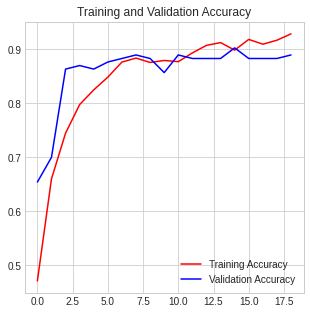

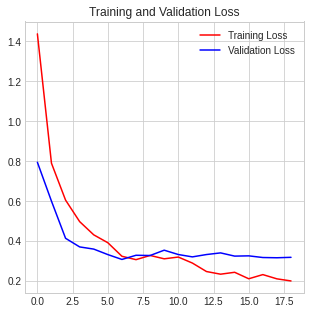

In [14]:
model_inception.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
history_inception = model_inception.fit(train_generator,
                              epochs=100,
                              callbacks = [reduce_lr, early_stop],
                              verbose=1,
                              validation_data=validation_generator)
plot_history(history_inception)

The training result speaks for itself. Using transfer learning as well as callbacks, we achieved a 92% accuracy for our training set and 89% for our validation set. This result does not show that our model overfits nor underfit. 

Also, the callbacks stopped our training below 30 epochs. If we don't use callbacks, we will be training until 100 epochs, and wasting more than 70 epochs. The callbacks also automated adjustment of learning rate for us. 

## Part 4: Evaluation

In this last part, we're going to get ourselves a full classification report score (not only an overall accuracy score). We'll see if the high accuracy is obtained in all 3 classes. 

In [15]:
num_of_test_samples = 159
from sklearn.metrics import classification_report, confusion_matrix

model = model_inception
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=159,
                                                              class_mode='categorical',
                                                              target_size=(150, 150),
                                                              shuffle = False)

filenames = validation_generator.filenames
nb_samples = len(filenames)
Y_pred = model.predict_generator(validation_generator, steps = nb_samples)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Macbook', 'iPad', 'iPhone']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Found 153 images belonging to 3 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[38  2  1]
 [ 1 47  8]
 [ 2  4 50]]
Classification Report
              precision    recall  f1-score   support

     Macbook       0.93      0.93      0.93        41
        iPad       0.89      0.84      0.86        56
      iPhone       0.85      0.89      0.87        56

    accuracy                           0.88       153
   macro avg       0.89      0.89      0.89       153
weighted avg       0.88      0.88      0.88       153



Our precision, recall, and f-1 score are high for all three classes. This is good news. We can thus conclude that our model performed really well to classify these three apple products.

The last part is to detect which images that our model predicts wrongly. This is just to satisfy our curiosity, as well as analyzing potential weakness of our model.

In [16]:
def find_wrong_predict(prediction, actual):
  product_dict = {
    0: 'Macbook',
    1: 'iPad',
    2: 'iPhone'
  }
  wrong_index = list()
  wrong_prediction = list()
  actual_label = list()
  for i in range(len(prediction)):
    if prediction[i] == actual[i]:
      pass
    else:
      wrong_index.append(i)
      wrong_prediction.append(product_dict[prediction[i]])
      actual_label.append(product_dict[actual[i]])

    df = pd.DataFrame(list(zip(wrong_index, wrong_prediction, actual_label)),
                      columns = ['Index', 'Predicted Label', 'Actual Label'])
  
  return df

In [17]:
wrong_classify = find_wrong_predict(y_pred, validation_generator.classes)
wrong_classify

,Index,Predicted Label,Actual Label
0,21,iPad,Macbook
1,23,iPad,Macbook
2,25,iPhone,Macbook
3,54,iPhone,iPad
4,57,iPhone,iPad
5,64,iPhone,iPad
6,67,iPhone,iPad
7,74,iPhone,iPad
8,82,iPhone,iPad
9,86,Macbook,iPad


In [18]:
def show_misclassified(index):
  x,y = validation_generator.next()
  image = x[index]
  print('==================')
  plt.figure(figsize=(3,3))
  plt.imshow(image)
  plt.show()
  print('Actual Image :', str(wrong_classify[wrong_classify['Index']==index]['Actual Label'].values)[2:-2])
  print('Predicted Label:', str(wrong_classify[wrong_classify['Index']==index]['Predicted Label'].values)[2:-2])
  print('==================')

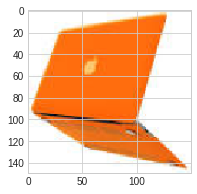

Actual Image : Macbook
Predicted Label: iPad


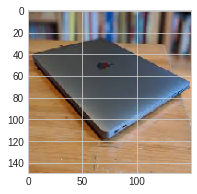

Actual Image : Macbook
Predicted Label: iPad


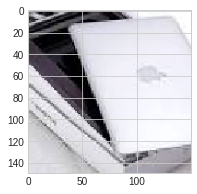

Actual Image : Macbook
Predicted Label: iPhone


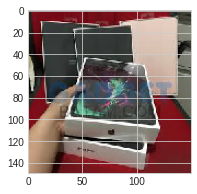

Actual Image : iPad
Predicted Label: iPhone


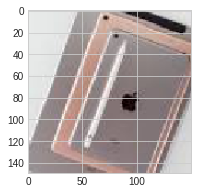

Actual Image : iPad
Predicted Label: iPhone


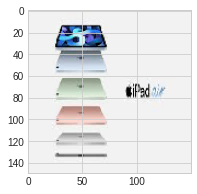

Actual Image : iPad
Predicted Label: iPhone


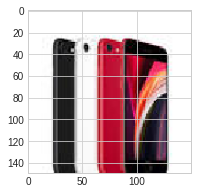

Actual Image : iPad
Predicted Label: iPhone


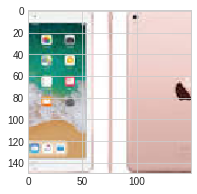

Actual Image : iPad
Predicted Label: iPhone


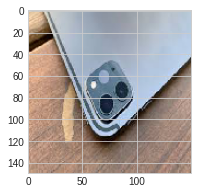

Actual Image : iPad
Predicted Label: iPhone


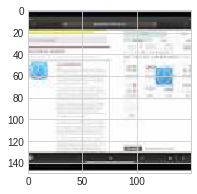

Actual Image : iPad
Predicted Label: Macbook


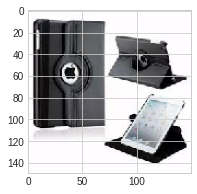

Actual Image : iPad
Predicted Label: iPhone


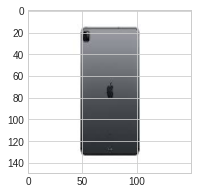

Actual Image : iPad
Predicted Label: iPhone


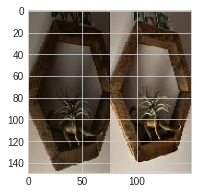

Actual Image : iPhone
Predicted Label: Macbook


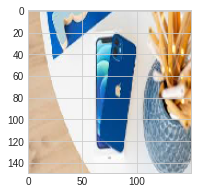

Actual Image : iPhone
Predicted Label: iPad


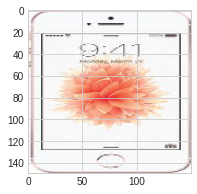

Actual Image : iPhone
Predicted Label: iPad


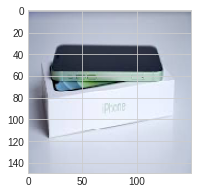

Actual Image : iPhone
Predicted Label: Macbook


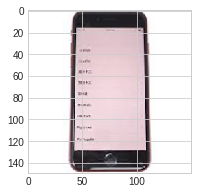

Actual Image : iPhone
Predicted Label: iPad


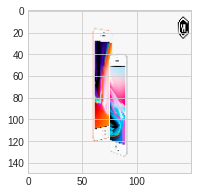

Actual Image : iPhone
Predicted Label: iPad


In [19]:
for index in wrong_classify.Index:
  show_misclassified(index)

Upon inspecting our wrongly classified images, here are the takeaways:
- If the iPad image comes with a keyboard, sometimes the model classifies it as a Macbook
- If the iPhone model has no notch (the iPhone 6, 7, 8 design), sometimes the model classifies it as an iPad
- Thus, iPad is the class with the lowest accuracy at 86%. Although, a 86% accuracy is already relatively high.

## Conclusion

- Convolutional Neural Network is suitable for image classification task
- Transfer learning helps us by allowing us to use a portion of trained layers
- Using callbacks make our training process 'easier' as we don't have to adjust things manually per epoch
- Using the top 500-600 images from Google Image Search, our model can classify Apple products (iPad, iPhone, Macbook) with 88-89% accuracy (on validation set).

In [20]:
model_inception.save_weights('model_inception_weights.h5')
model_inception.save('model_inception.h5')

## Epilogue: Function to Predict Image (used in streamlit app)

In [85]:
def predict_image(image, withpath, model = model_inception):
  if withpath == True:
    from PIL import Image
    im = Image.open(image)
  else:
    im = image

  resized_im = im.resize((150, 150))
  im_array = np.asarray(resized_im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 150, 150, 3])

  predict_array = model.predict(im_input)[0]
  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Macbook', 'iPad', 'iPhone']
  df['Product'] = prod
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
    predict_product = 'The uploaded image resembles a Macbook.'
  elif predict_label == 1:
    predict_product = 'The uploaded image resembles an iPad.'
  else:
    predict_product = 'The uploaded image resembles an iPhone.'


  return predict_product, df

In [87]:
# image = Image.open('/content/sampleiphone.jpg')
# label, df = predict_image(image, withpath=False)
# print(label)
# print(df)

iPhone
   Product  Probability
0  Macbook     0.118985
1     iPad     0.304012
2   iPhone     0.577003
